In [83]:
import matplotlib
import pandas as pd
%matplotlib inline
# 数据读取
datatmsp = pd.read_excel('./data/datastmsp.xls')
datatmsp.shape

(4392, 25)

### 数据清洗、处理

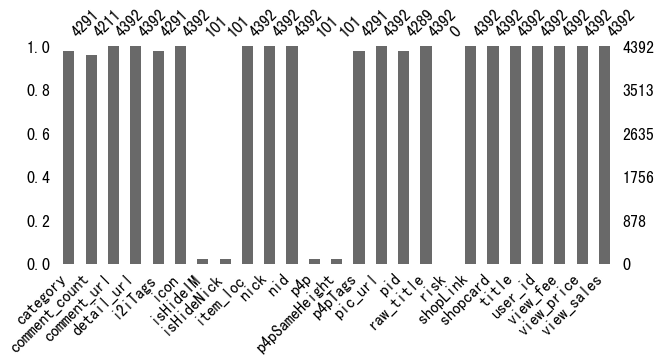

In [22]:
import missingno as msno
msno.bar(datatmsp.sample(len(datatmsp)), figsize=(10, 4))

# 删除缺失值过半的列
half_count = len(datatmsp)/2
datatmsp = datatmsp.dropna(thresh=half_count, axis=1)
datatmsp = datatmsp.drop_duplicates()

###  本案例取 item_loc, raw_title, view_price, view_sales 标题，区域，价格，销量进行分析

In [24]:
data = datatmsp[
    ['item_loc', 'raw_title', 'view_price', 'view_sales']
]
data.head()

,item_loc,raw_title,view_price,view_sales
0,广东 佛山,现代简约家具沙发组合客厅套装实木布艺沙发,3880.0,1134人付款
1,广东 佛山,林氏木业北欧实木简约布沙发床小户型布艺沙发折叠三人座客厅1012,2060.0,568人付款
2,四川 成都,全友家私沙发简约客厅皮布艺沙发可拆洗小户型整装沙发组合102085,8997.0,203人付款
3,广东 佛山,简约现代布艺沙发 小户型客厅家具整装转角组合 可拆洗三人位沙发,888.0,2483人付款
4,广东 佛山,真皮沙发头层牛皮简约现代大户型整装家具客厅转角皮艺沙发组合,3250.0,1781人付款


In [27]:
data['sales'] = data.sales.astype('int')
list_col = ['province', 'city']
for i in list_col:
    data[i] = data[i].astype('category')

data = data.drop(['item_loc', 'view_sales'], axis=1)
data.head()

c:\env\ai\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\env\ai\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,raw_title,view_price,province,city,sales
0,现代简约家具沙发组合客厅套装实木布艺沙发,3880.0,广东,佛山,1134
1,林氏木业北欧实木简约布沙发床小户型布艺沙发折叠三人座客厅1012,2060.0,广东,佛山,568
2,全友家私沙发简约客厅皮布艺沙发可拆洗小户型整装沙发组合102085,8997.0,四川,成都,203
3,简约现代布艺沙发 小户型客厅家具整装转角组合 可拆洗三人位沙发,888.0,广东,佛山,2483
4,真皮沙发头层牛皮简约现代大户型整装家具客厅转角皮艺沙发组合,3250.0,广东,佛山,1781


### 数据挖掘和分析

In [38]:
# 先用jieba分词对标题进行分析

title = data.raw_title.values.tolist()
import jieba
title_s = []
for line in title:
    title_cut = jieba.lcut(line)
    title_s.append(title_cut)

# 剔除不需要的单词，使用停用表
stopwords = pd.read_excel('./data/stopwords.xlsx')
stopwords = stopwords.stopword.values.tolist()

title_clean = []
for line in title_s:
    line_clean = []
    for word in line:
        if word not in stopwords:
            line_clean.append(word)
    title_clean.append(line_clean)

# 统计每个词语的个数，先去重
title_clean_dist = []
for line in title_clean:
    line_dist = []
    for word in line:
        if word not in line_dist:
            line_dist.append(word)
    title_clean_dist.append(line_dist)

# 将所有词转换为一个list
allwords_clean_dist = []
for line in title_clean_dist:
    for word in line:
        allwords_clean_dist.append(word)

# 将所有词语转换数据框
df_allwords_clean_dist = pd.DataFrame({
    'allwords': allwords_clean_dist
})

word_count = df_allwords_clean_dist.allwords.value_counts().reset_index()
word_count.columns = ['word', 'count']
word_count.head()

,word,count
0,沙发,3301
1,组合,3264
2,客厅,3174
3,小户型,2685
4,简约,2295


### 对关键词进行分析

In [61]:
import numpy as np

w_s_sum = []
for w in word_count.word:
    i = 0
    s_list = []
    for t in title_clean_dist:
        if w in t:
            try:
                s_list.append(data.sales[i])
            except:
                s_list.append(0)
        i += 1
    w_s_sum.append(sum(s_list))

df_w_s_sum = pd.DataFrame({'w_s_sum':w_s_sum})

In [63]:
df_w_s_sum.head()

,w_s_sum
0,642537
1,673516
2,645872
3,612844
4,567795


In [64]:
word_count.head()

,word,count
0,沙发,3301
1,组合,3264
2,客厅,3174
3,小户型,2685
4,简约,2295


In [66]:
df_word_sum = pd.concat([word_count, df_w_s_sum],
                        axis=1,
                        ignore_index=True)
df_word_sum.columns = ['word', 'count', 'w_s_sum']
df_word_sum.head(30)

,word,count,w_s_sum
0,沙发,3301,642537
1,组合,3264,673516
2,客厅,3174,645872
3,小户型,2685,612844
4,简约,2295,567795
5,整装,1938,514951
6,布艺沙发,1905,479734
7,家具,1517,345293
8,实木,1462,209360
9,北欧,1313,266916


###  数据可视化

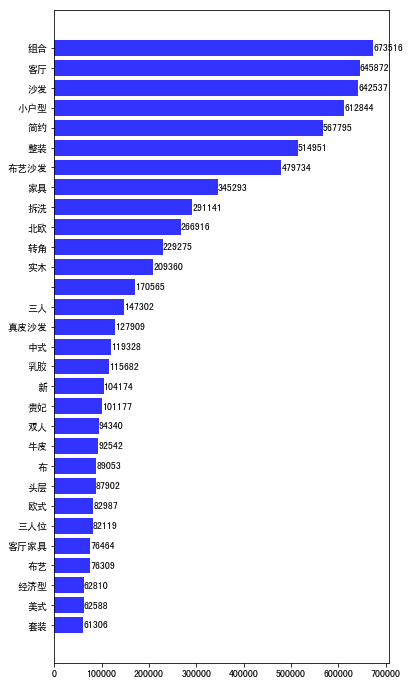

In [71]:
df_word_sum.sort_values('w_s_sum',
                       inplace=True,
                       ascending=True)
df_w_s = df_word_sum.tail(30)
import matplotlib
from matplotlib import pyplot as plt
font = matplotlib.font_manager.FontProperties(fname='./data/simhei.ttf')

index = np.arange(df_w_s.word.size)

plt.figure(figsize=(6,12))
plt.barh(index,
         df_w_s.w_s_sum,
         color='blue', 
         align='center',
         alpha=0.8)

plt.yticks(index,  list(df_w_s.word), fontproperties=font)

for y,x in zip(index, df_w_s.w_s_sum):
    plt.text(x,y,"%.0f" %x, ha='left', va='center')

plt.show()

####  分析结论: 1. 客厅、组合、沙发、整装商品占比很高
#### 2. 从沙发材质 布艺沙发占比高
#### 3. 从沙发风格看，简约风格最多 
#### 4. 从户型看，小户型

##  商品的价格分布情况分析

In [72]:
data.head()

,raw_title,view_price,province,city,sales
0,现代简约家具沙发组合客厅套装实木布艺沙发,3880.0,广东,佛山,1134
1,林氏木业北欧实木简约布沙发床小户型布艺沙发折叠三人座客厅1012,2060.0,广东,佛山,568
2,全友家私沙发简约客厅皮布艺沙发可拆洗小户型整装沙发组合102085,8997.0,四川,成都,203
3,简约现代布艺沙发 小户型客厅家具整装转角组合 可拆洗三人位沙发,888.0,广东,佛山,2483
4,真皮沙发头层牛皮简约现代大户型整装家具客厅转角皮艺沙发组合,3250.0,广东,佛山,1781


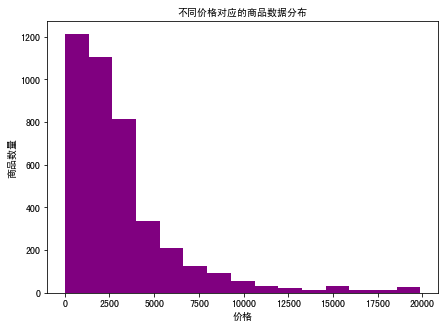

In [73]:
data_p = data[data['view_price'] < 20000]

plt.figure(figsize=(7, 5))
plt.hist(data_p['view_price'], bins=15, color='purple')
plt.xlabel(u'价格', fontproperties=font)
plt.ylabel(u'商品数量', fontproperties=font)
plt.title(u'不同价格对应的商品数据分布', fontproperties=font)
plt.show()

#### 由上图表可知：商品数量随着价格总体呈现下降阶梯形势，价格越高，在售的商品越少

### 商品的销量分布情况分析

销量100以上的商品占比 : 0.356


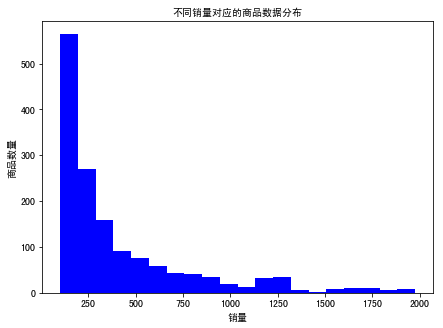

In [74]:
data_s = data[(data['sales'] > 100) & (data['sales'] < 2000)]
print(u'销量100以上的商品占比 : %0.3f' % (len(data_s)/len(data)))

plt.figure(figsize=(7, 5))
plt.hist(data_s['sales'], bins=20, color='blue')
plt.xlabel(u'销量', fontproperties=font)
plt.ylabel(u'商品数量', fontproperties=font)
plt.title(u'不同销量对应的商品数据分布', fontproperties=font)
plt.show()

#### 根据图表分析可知: 1. 销量100以上的商品仅占3.4%,其中销量100-200商品最多，200-300次之 2. 销量100-500之间，商品的数量随着销量呈现下降趋势，且趋势陡峭，低销量商品居多； 3. 销量750以上的商品很少。

In [75]:
#  不同价格区间的商品平均销量分布
data['price'] = data.view_price.astype('int')
data['group'] = pd.qcut(data.price, 12)
df_group = data.group.value_counts().reset_index()

df_s_g = data[
    ['sales','group']
].groupby('group').mean().reset_index()

df_s_g

,group,sales
0,"(17.999, 496.25]",410.353448
1,"(496.25, 897.667]",265.953890
2,"(897.667, 1180.0]",448.923295
3,"(1180.0, 1499.0]",215.823699
4,"(1499.0, 1880.0]",217.104558
5,"(1880.0, 2288.5]",138.605016
6,"(2288.5, 2799.917]",219.417867
7,"(2799.917, 3380.0]",148.728045
8,"(3380.0, 3990.0]",82.276968
9,"(3990.0, 5360.0]",60.461318


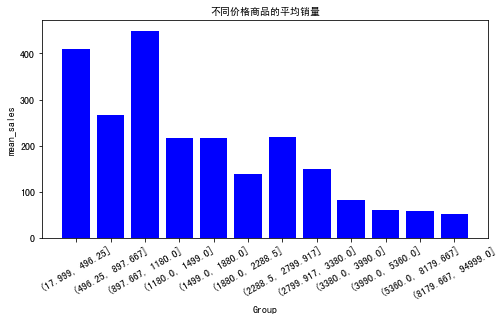

In [76]:
index = np.arange(df_s_g.group.size)
plt.figure(figsize=(8,4))
plt.bar(index, df_s_g.sales, color='blue')
plt.xticks(index, df_s_g.group, fontproperties=font, rotation=30)
plt.xlabel('Group')
plt.ylabel('mean_sales')
plt.title(u'不同价格商品的平均销量',fontproperties=font)
plt.show()

#### 由图表可知： 1. 价格在496-897之间的商品平均销量最高，18-496之间的次之，5360元以上的最低；   总体呈现减的趋势

In [78]:
data_p.shape

(4096, 5)

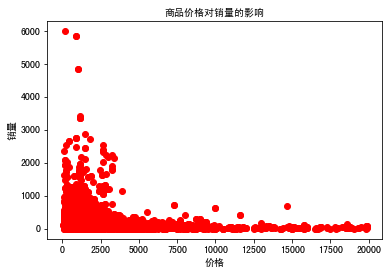

In [79]:
fig, ax = plt.subplots()
ax.scatter(data_p['view_price'],data_p['sales'], color='red')
ax.set_xlabel(u'价格')
ax.set_ylabel(u'销量')
ax.set_title(u'商品价格对销量的影响',fontproperties=font)
plt.show()

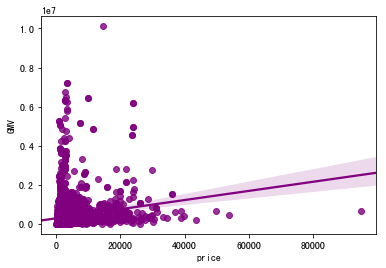

In [80]:
data['GMV'] = data['price'] * data['sales']

import seaborn as sns
sns.regplot(x='price', y='GMV', data=data, color='purple')

由图表可知：

总体趋势：由线性回归拟合线可以看出，商品销售额随着价格增长呈现上升趋势；

多数商品的价格偏低，销售额也偏低；

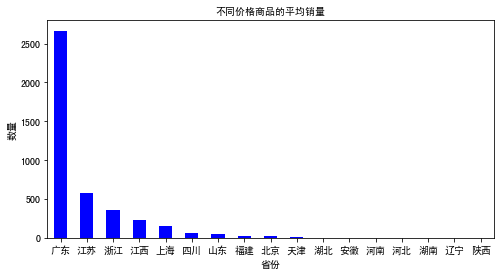

In [81]:
plt.figure(figsize=(8,4))
data.province.value_counts().plot(kind='bar', color='blue')
plt.xticks(rotation=0,fontproperties=font)
plt.xlabel(u'省份',fontproperties=font)
plt.ylabel(u'数量',fontproperties=font)
plt.title(u'不同价格商品的平均销量',fontproperties=font)
plt.show()

#### 由省份-商品数量关系图分析得知：广东的最多，江苏次之，浙江第三，尤其是广东的数量远超过江苏、浙江、上海等地，说明在沙发这个子类目，广东的店铺占主导地位；江浙沪等地的数量差异不大，基本相当。